In [3]:
%load_ext autoreload
%autoreload 2

from text3d2video.feature_visualization import reduce_feature_map
from text3d2video.util import sample_feature_map
from torch import Tensor
from einops import einsum
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import torch.nn.functional as F
from text3d2video.artifacts.attn_features_artifact import AttentionFeaturesArtifact
from math import sqrt
from text3d2video.attention_visualization import split_heads
import text3d2video.wandb_util as wbu

from einops import rearrange

artifact_tag = "attn_data:latest"
attn_data = AttentionFeaturesArtifact.from_wandb_artifact_tag(
    artifact_tag, download=True
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact attn_data:latest, 13221.29MB. 325 files... 
wandb:   325 of 325 files downloaded.  
Done. 0:0:25.5


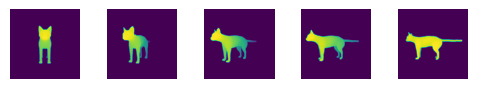

In [7]:
from omegaconf import OmegaConf

from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

run = attn_data.logged_by()
run_config = OmegaConf.create(run.config)

n_frames = run_config.animation.n_frames
anim = wbu.first_used_artifact_of_type(run, 'animation')
anim = AnimationArtifact.from_wandb_artifact(anim)

frame_nums = anim.frame_nums(n_frames)
cameras = anim.cameras(frame_nums)
meshes = anim.load_frames(frame_nums)

depth_maps = render_depth_map(meshes, cameras)
display_ims(depth_maps)

In [8]:
# read data
multidict = attn_data.get_features_diskdict()
images = attn_data.get_images()
layer_names = sorted(multidict.key_values("layer"))
time_steps = sorted(multidict.key_values("timestep"))

dec_layers = [layer for layer in layer_names if "up_blocks" in layer]
enc_layers = [layer for layer in layer_names if "down_blocks" in layer]

for layer in layer_names:
    print(layer)

down_blocks.0.attentions.0.transformer_blocks.0.attn1
down_blocks.0.attentions.1.transformer_blocks.0.attn1
down_blocks.1.attentions.0.transformer_blocks.0.attn1
down_blocks.1.attentions.1.transformer_blocks.0.attn1
down_blocks.2.attentions.0.transformer_blocks.0.attn1
down_blocks.2.attentions.1.transformer_blocks.0.attn1
mid_block.attentions.0.transformer_blocks.0.attn1
up_blocks.1.attentions.0.transformer_blocks.0.attn1
up_blocks.1.attentions.1.transformer_blocks.0.attn1
up_blocks.1.attentions.2.transformer_blocks.0.attn1
up_blocks.2.attentions.0.transformer_blocks.0.attn1
up_blocks.2.attentions.1.transformer_blocks.0.attn1
up_blocks.2.attentions.2.transformer_blocks.0.attn1
up_blocks.3.attentions.0.transformer_blocks.0.attn1
up_blocks.3.attentions.1.transformer_blocks.0.attn1
up_blocks.3.attentions.2.transformer_blocks.0.attn1


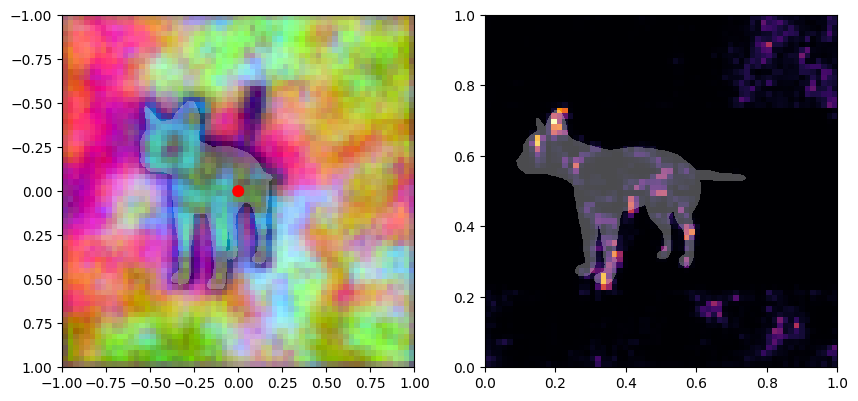

In [9]:

from matplotlib.colors import ListedColormap


def plot_feature_sim(layer_name, time_step, pixel_coord):

    identifier = {"layer": layer_name, "timestep": time_step}

    # get queries keys and values
    qrys = multidict[identifier | {"name": "query"}][: len(images)]
    # keys = multidict[identifier | {"name": "key"}][: len(images)]
    # vals = multidict[identifier | {"name": "value"}][: len(images)]

    layer_res = int(sqrt(qrys.shape[1]))

    # reshape q/k/v to b t h w d
    qrys_multihead = split_heads(qrys)
    # keys_multihead = split_heads(keys)
    # vals_multihead = split_heads(vals)

    head_idx = 0
    frame_idx = 1
    frame_idx_tgt = 2

    # get query, key, value for head
    head_qrys = qrys_multihead[:, :, head_idx, :]
    # head_keys = keys_multihead[:, :, head_idx, :]
    # head_vals = vals_multihead[:, :, head_idx, :]

    # reshape query
    q_square = rearrange(head_qrys[frame_idx], "(h w) d -> d h w", h=layer_res)
    q_square_tgt = rearrange(head_qrys[frame_idx_tgt], "(h w) d -> d h w", h=layer_res)

    # get query feature
    pixel_qry = sample_feature_map(q_square, pixel_coord.unsqueeze(0), mode="nearest")[0]

    tgt_feature_map = q_square_tgt
    similarities = einsum(pixel_qry, tgt_feature_map, "d, d h w -> h w")
    similarities = F.softmax(similarities / (1 * sqrt(q_square.shape[0])), dim=-1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    ax_q = axs[0]
    ax_sim = axs[1]

    ax_q.imshow(reduce_feature_map(q_square), extent=[-1, 1, 1, -1])
    # add marker on qry axis
    patch = Circle(pixel_coord, 0.03, color="red")
    ax_q.add_patch(patch)

    depth_map_src = depth_maps[frame_idx]
    depth_map_tgt = depth_maps[frame_idx_tgt]

    ax_sim.imshow(
        similarities.detach().numpy(), extent=[0, 1, 0, 1], alpha=1, cmap="inferno"
    )

    transparent_cmap = ListedColormap(["none"] + ["white"] * 5)
    ax_sim.imshow(
        depth_map_tgt, extent=[0, 1, 0, 1], cmap=transparent_cmap, alpha=0.3
    )
    ax_q.imshow(
        depth_map_src, extent=[-1, 1, 1, -1], cmap=transparent_cmap, alpha=0.3
    )

pixel_coord = Tensor([0, 0])
layer_name = dec_layers[-1]
layer_name = enc_layers[0]

time_step = time_steps[4]
plot_feature_sim(layer_name, time_step, pixel_coord)